In [2]:
import pandas as pd
import os
from erddapy import ERDDAP
import numpy as np
import hvplot.pandas
import datashader as ds
import datetime as dt

e = ERDDAP(server="https://dev.cioosatlantic.ca/erddap",
                 protocol="tabledap", )
e.auth = ("cioosatlantic", "4oceans")
e.response = "csv"
e.dataset_id = 'Mar2018_44fa_e1cc_fc53'
e.constraints = { "time<=": "2018-05-23T17:47:30Z", 
                  "time>=": '2018-03-30T20:02:33Z',
                 "Vel_East!=":0,
                 "Vel_North!=":0,
                }
e.variables = ['time','Vel_East','Vel_North','BurstVelocityENU_Range']
df = e.to_pandas()
df['time (UTC)'] = pd.to_datetime(df['time (UTC)'], format="%Y-%m-%dT%H:%M:%SZ")

df

time (UTC)  Vel_East (m/s)  Vel_North (m/s)  \
0      2018-03-30 20:02:33       -1.339414         0.652549   
1      2018-03-30 20:17:30       -1.419244         0.613709   
2      2018-03-30 20:32:30       -1.213854         0.618212   
3      2018-03-30 20:47:30       -1.163068         0.552753   
4      2018-03-30 21:02:30       -1.073227         0.500657   
...                    ...             ...              ...   
165318 2018-05-18 06:32:30        0.636833        -0.690044   
165319 2018-05-18 06:47:30       -0.355382        -0.171419   
165320 2018-05-19 06:47:30        1.950108        -1.191236   
165321 2018-05-19 07:02:30        1.414966        -0.989659   
165322 2018-05-19 07:17:30        0.847385        -0.828366   

        BurstVelocityENU_Range (m)  
0                              1.5  
1                              1.5  
2                              1.5  
3                              1.5  
4                              1.5  
...                            ...  
165318                        38.5  
165319                        38.5  
165320                        38.5  
165321                        38.5  
165322                        38.5  

[165323 rows x 4 columns]

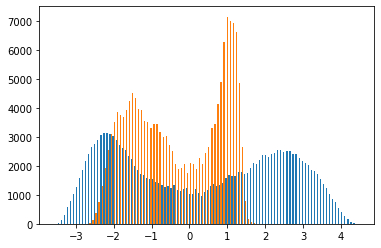

In [3]:
import matplotlib.pyplot as plt
X = df.iloc[:,1:3].values

plt.hist(X, bins = 100);

In [4]:
# def standardize_data(arr):
         
#     '''
#     This function standardize an array, its substracts mean value, 
#     and then divide the standard deviation.
    
#     param 1: array 
#     return: standardized array
#     '''    
    
#     mean = np.mean(X, axis=None)
#     std = np.std(X, axis=None)
 
#     standardizedArray = (X - mean) / std
 
    
#     return standardizedArray

#X = standardize_data(X)

In [5]:
print(np.mean(X,axis=0),np.std(X,axis=0))

[ 0.28630302 -0.32237213] [2.13740085 1.17783688]


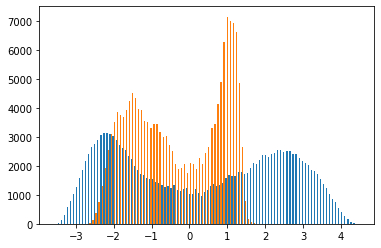

In [6]:
X
plt.hist(X, bins =100);


In [7]:
covariance_matrix = np.cov(X.T)
covariance_matrix

array([[ 4.56851003, -2.50227172],
       [-2.50227172,  1.38730811]])

In [8]:
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print("Eigenvector: \n",eigen_vectors,"\n")
print("Eigenvalues: \n", eigen_values, "\n")

Eigenvector: 
 [[ 0.87648572  0.48142786]
 [-0.48142786  0.87648572]] 

Eigenvalues: 
 [5.94293439 0.01288374] 



In [9]:
# Calculating the explained variance on each of components

variance_explained = []
for i in eigen_values:
     variance_explained.append((i/sum(eigen_values))*100)
        
print(variance_explained)

[99.78367801516553, 0.21632198483445975]


In [10]:
# Identifying components that explain at least 95%

cumulative_variance_explained = np.cumsum(variance_explained)
print(cumulative_variance_explained)

[ 99.78367802 100.        ]


Text(0.5, 1.0, 'Explained variance vs Number of components')

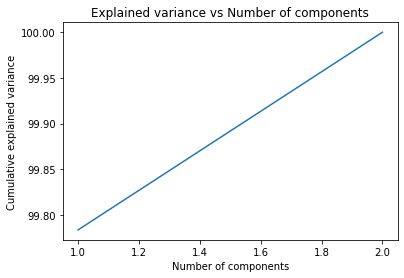

In [11]:
# Visualizing the eigenvalues
%matplotlib inline
import matplotlib.pyplot as plt

x = [1,2]
plt.plot(x,cumulative_variance_explained)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")

In [12]:
# Using the first component (because this explains more than 95%)

projection_matrix = (eigen_vectors.T[:][:1]).T
print(projection_matrix)

[[ 0.87648572]
 [-0.48142786]]


In [13]:
# Getting the product of original standardized X and the eigenvectors 

X_pca = X.dot(projection_matrix)
print(X_pca)
print(X_pca.shape)

[[-1.48813217]
 [-1.53940404]
 [-1.36154976]
 ...
 [ 2.28273574]
 [ 1.71664675]
 [ 1.14151894]]
(165323, 1)


In [14]:
df_pca = pd.DataFrame(X_pca, columns = ['Channel Velocity (m/s)'])
df_pca

Channel Velocity (m/s)
0                    -1.488132
1                    -1.539404
2                    -1.361550
3                    -1.285523
4                    -1.181698
...                        ...
165318                0.890381
165319               -0.228961
165320                2.282736
165321                1.716647
165322                1.141519

[165323 rows x 1 columns]

In [15]:
fulldata = pd.concat([df, df_pca], axis=1)
fulldata = fulldata.rename(columns = {'time (UTC)':'time'})


In [16]:
#adding directions
fulldata['Vel_Mag']=((fulldata['Vel_East (m/s)']**2)+(fulldata['Vel_North (m/s)']**2))**0.5

fulldata

time  Vel_East (m/s)  Vel_North (m/s)  \
0      2018-03-30 20:02:33       -1.339414         0.652549   
1      2018-03-30 20:17:30       -1.419244         0.613709   
2      2018-03-30 20:32:30       -1.213854         0.618212   
3      2018-03-30 20:47:30       -1.163068         0.552753   
4      2018-03-30 21:02:30       -1.073227         0.500657   
...                    ...             ...              ...   
165318 2018-05-18 06:32:30        0.636833        -0.690044   
165319 2018-05-18 06:47:30       -0.355382        -0.171419   
165320 2018-05-19 06:47:30        1.950108        -1.191236   
165321 2018-05-19 07:02:30        1.414966        -0.989659   
165322 2018-05-19 07:17:30        0.847385        -0.828366   

        BurstVelocityENU_Range (m)  Channel Velocity (m/s)   Vel_Mag  
0                              1.5               -1.488132  1.489916  
1                              1.5               -1.539404  1.546251  
2                              1.5               -1.361550  1.362214  
3                              1.5               -1.285523  1.287736  
4                              1.5               -1.181698  1.184261  
...                            ...                     ...       ...  
165318                        38.5                0.890381  0.938998  
165319                        38.5               -0.228961  0.394564  
165320                        38.5                2.282736  2.285162  
165321                        38.5                1.716647  1.726718  
165322                        38.5                1.141519  1.185011  

[165323 rows x 6 columns]

In [17]:
import hvplot.pandas
import holoviews.operation.datashader as hd
import datashader as ds
import holoviews as hv

plot = fulldata.hvplot.scatter(x = 'time', y=['Vel_East (m/s)', 
                                                    
                                                    'Channel Velocity (m/s)'
                                                   ]
                               ,datashade=True, subplots=True,width=800,aggregator = 'mean')
spreadplot = hd.dynspread(plot, threshold=.999, max_px=2)
spreadplot.cols(1)

:NdLayout   [Variable]
   :DynamicMap   []
      :RGB   [time,value]   (R,G,B,A)

In [18]:

hmap = aprildata.hvplot.heatmap(x='time',y='BurstVelocityENU_Range (m)', C = 'Channel Velocity (m/s)'
                               ,height=500, width=500, colorbar=True)
hmap.aggregate(function=np.mean)

NameError: name 'aprildata' is not defined

In [45]:
data = fulldata.copy()
data = data.sort_values(by=['time'])
data['time (UTC)'] = pd.to_datetime(data['time'], format="%Y-%m-%dT%H:%M:%SZ")
data = data.set_index(data['time'].astype(np.datetime64))
aprildata = data.loc['2018-04-01':'2018-04-07']
maydata = data.loc['2018-05']
del aprildata['time']
del maydata['time']
def moving_average(a, n=48) :
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [46]:
hmapapril = aprildata.hvplot.heatmap(x='time',y='BurstVelocityENU_Range (m)', C = 'Channel Velocity (m/s)'
                               ,height=500, width=1000, colorbar=True, cmap = 'Spectral', clim = (-3,3))

hmapmay = maydata.hvplot.heatmap(x='time',y='BurstVelocityENU_Range (m)', C = 'Channel Velocity (m/s)'
                               ,height=500, width=1200, colorbar=True)

hmapapril

:HeatMap   [time,BurstVelocityENU_Range (m)]   (Channel Velocity (m/s))

In [42]:
aprildata
aprildata['Channel Velocity (m/s)'].rolling(48).mean()

time
2018-04-01 00:02:30         NaN
2018-04-01 00:02:30         NaN
2018-04-01 00:02:30         NaN
2018-04-01 00:02:30         NaN
2018-04-01 00:02:30         NaN
                         ...   
2018-04-30 23:47:30    0.852823
2018-04-30 23:47:30    0.866194
2018-04-30 23:47:30    0.879987
2018-04-30 23:47:30    0.891080
2018-04-30 23:47:30    0.906097
Name: Channel Velocity (m/s), Length: 92070, dtype: float64

In [255]:
b = ERDDAP(server="https://dev.cioosatlantic.ca/erddap",
                 protocol="tabledap", )
b.auth = ("cioosatlantic", "4oceans")
b.response = "csv"
b.dataset_id = 'Mar2018_877c_2e5e_2fd0'
b.constraints = { "time<=": "2018-05-23T17:47:30Z", 
                  "time>=": '2018-03-30T20:02:33Z',
                }
b.variables = [' ASTSpectra_Energy','ASTSpectra_Frequency',]
df1 = b.to_pandas()

In [246]:
spectrum = df1.hvplot.line(x='ASTSpectra_Frequency (Hz)', y = 'ASTSpectra_Energy (m^2/Hz)', datashade = True, logy=True, aggregator='count'  )
spectrumsp =hd.dynspread(spectrum, threshold=.999, max_px=2)
spectrumsp

:DynamicMap   []
   :RGB   [ASTSpectra_Frequency (Hz),ASTSpectra_Energy (m^2/Hz)]   (R,G,B,A)